#### [ML with Python] 2. 지도 학습 알고리즘 (5-1) 커널 서포트 벡터 머신
- 본 포스팅은 지도 학습 알고리즘인 커널 서포트 벡터 머신(SVM)에 관한 기본적인 내용에 관하여 다룹니다.
- 커널 서포트 벡터 머신(`kernelized support vector machines`)
- 선형 모델과 비선형 특성
- 커널 기법(`Kernel Trick`)
- SVM 매개변수 튜닝
- SVM을 위한 데이터 전처리
- 커널 서포트 벡터 머신의 장단점

___

필요 라이브러리 import

In [115]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D, axes3d
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

---

#### <u>커널 서포트 벡터 머신(kernelized support vector machines)</u>
이전 포스팅 [`분류용 선형 모델`](https://jhryu1208.github.io/data/2020/11/13/ML_classification_linear_regression/)에서 `선형 서포트 백터 머신(SVM)`을 이용해 분류 문제를 풀어보았었다.

- 입력데이터에서 단순한 초평면(?)으로 정의되지 않는 <u>더 복잡한 모델을 만들 수 있도록</u> 확장한 모델
- `분류`와 `회귀`에서 모두 사용할 수 있지만, 여기서는 분류 문제만 다룰 것이다.
    - 물론 `SVR`를 사용하는 회귀 문제에서도 같은 개념을 적용할 수 있다.
    
> `초평면` 이란?<br>
> <br>
> p개의 변수 x1,x2,...,xp 의 p차원 공간에서 “초평면”은 “응축된(flat)" (p-1)차원 부분 공간(subspace) 이다.<br>
> 여기서 “응축된”이란 말은 부피(volume)가 0 이라는 의미이다. <br>
> 예를 들어서 1, 2, 3차원 공간에서 초평면은 각각 점, 선, 평면을 말한다.<br>
> 4차원 이상에서는 달리 표현하는 용어가 없으므로 총칭하여 초평면이라 부른다.

<br>

`SVM`의 수학적 정의는 복잡하여 다음을 참고할 것을 권장한다.<br>
[헤이스티, 팁시라니, 프리드먼의 『The Elements of Statistical Learning』](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

<br>

알고리즘의 이면에 있는 아이디어 정도만 살펴보자.

<br>

---

#### <u>선형 모델과 비선형 특성</u>

직선과 초평면은 유연하지 못하여 저차원 데이터셋에서는 `선형 모델`이 매우 제한적이다.

<br>

선형 모델을 <b>유연</b>하게 만드는 방법은<br>
- 특성끼리의 곱셈
- 특성을 거듭제곱

식으로 <u>새로운 특성을 추가</u>하는 것이다.

<br>

`분류`를 위한 `선형 모델`은 <b>직선</b>으로만 데이터 포인트를 나눌 수 있어서 아래와 같은 데이터셋에서는 잘 들어 맞지 않는다. 

Text(0, 0.5, 'Property 1')

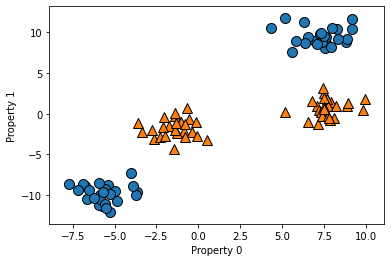

In [38]:
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Property 0")
plt.ylabel("Property 1")

C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Property 1')

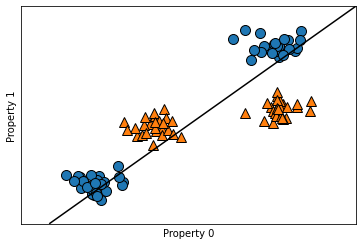

In [40]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Property 0")
plt.ylabel("Property 1")

<br>

두 번째 특성을 `(Property1)^2`를 새로운 특성으로 추가해 입력 특성을 확장해보자. 이제 (Property0, Property1)의 2차원 데이터 포인트가 아니라 (Property0, Property1, (Property1)^2)의 <b>3차원 데이터</b>로 표현된다. 그리고 이 데이터셋을 아래처럼 3차원 산점도로 나타낼 수 있다.

Text(0.5, 0, '(Property1)^2')

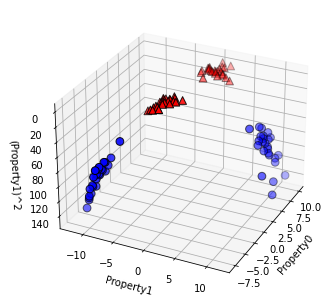

In [43]:
# 두 번째 특성을 제곱하여 추가합니다.
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0인 포인트를 먼저 그리고 그다음 y == 1인 포인트를 그립니다.
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("Property0")
ax.set_ylabel("Property1")
ax.set_zlabel("(Property1)^2")

<br>

새로운 데이터셋에는 선형 모델과 <b>3차원 공간</b>의 <b>평면</b>을 사용해 두 클래스를 구분할 수 있다. 확장된 데이터셋에서 `선형 모델`을 만들면 다음과 같다.

C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, '(Property1)^2')

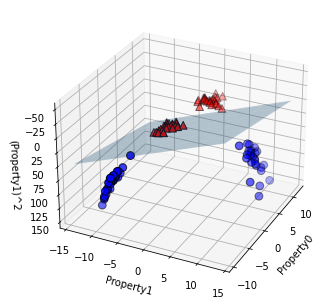

In [44]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
# 평면 방정식
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("Property0")
ax.set_ylabel("Property1")
ax.set_zlabel("(Property1)^2")

<br>

원래 특성으로 위의 모델을 투영해보면 `선형SVM`모델은 더 이상 선형이 아니다.<br>
직선보다 타원에 가까운 모습을 확인할 수 있다.

Text(0, 0.5, 'Property1')

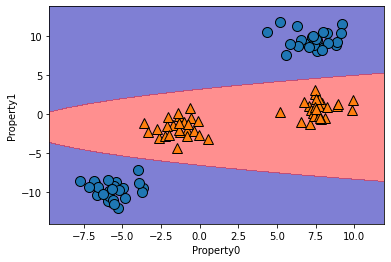

In [47]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Property0")
plt.ylabel("Property1")

<br>

---

#### <u>커널 기법(Kernel Trick)</u>

앞에서 데이터셋에 `비선형 특성`을 추가해서 `선형 모델`을 강력하게 만들었다. 하지만 어떤 특성을 추가해야 할지 모르고 특성을 많이 추가하면 연산 비용이 비이상적으로 커지게 된다. <u>다행히 수학적 기교를 사용해서 새로운 특성을 많이 만들지 않고서도 고차원에서 분류기를 학습시킬 수 있다</u>. 바로 이를 `커널 기법`이라 한다.

<br>

`커널 기법`은 실제로 데이터를 확장하지 않고, 확장된 특성에 대한 포인트들의 거리(더 정확히는 스칼라 곱)를 계산한다.

<br>

`서포트 벡터 머신`에서 데이터를 고차원 공간에 매핑하는 데 많이 사용하는 방법은 두가지 이다.
- `다항식 커널` : 원래 특성의 가능한 조합을 지정된 차수까지 모두 계산하는 방법 (ex. (Property1)^3 X (Property2)^5, ...)
- `가우시안 커널(혹은 RBF 커널)` : 차원이 무한한 특성 공간에 매핑하는 것으로, 모든 차수의 모든 다항식을 고려한다 이해하면 된다. 하지만 특성의 중요도는 고차항이 될수록 줄어든다.

<br>

실제로 `커널 SVM` 이면의 수학적인 이론은 중요하지 않지만,<br>
`RBF 커널`을 사용한 `SVM`이 결정을 만드는 방법은 비교적 쉽게 설명될 수 있다.<br>
이에 관하여 살펴보자.

<br>

---

#### <u> SVM이해하기 </u>

학습이 진행되는 동안 `SVM`은 각 훈련 데이터 포인트가 두 클래스 사이의 결정 경계를 구분하는데 얼마나 중요한지를 배우게 된다. 일반적으로 훈련 데이터의 일부만 결정 경계를 만드는 데 영향을 준다.

<br>

바로 <u>두 클래스 사이의 경계에 위치한 데이터 포인트</u>들이다.<br>
이런 데이터 포인트를 `서포트 벡터(support vector)`라 하며, 여기서 `SVM`의 이름이 유례되었다.

<br>

새로운 데이터 포인트에 대해 <b>예측</b>하려면 각 `서포트 벡터`와의 <b>거리</b>를 측정한다. 
- `분류 결정`은 `서포트 벡터`까지의 <b>거리</b>에 기반하고
- `서포트 벡터`의 <b>중요도</b>는 훈련 과정에서 학습한다.(`SVC`객체의 `dual_coef_`속성에 저장된다.)

<br>

데이터 포인트 사이의 거리는 `가우시안 커널`에 의해 계산된다.

<img width="500" alt="2" src="https://user-images.githubusercontent.com/53929665/99898017-91c80280-2ce1-11eb-85de-2d280e5ddc10.png">


- `x1과 x2` : 데이터 포인트
- `||x1-x2||` : 유클라디안 거리 
- `r(gamma)` : 가우시안 커널의 폭을 제어하는 매개변수

<br>

두 개의 클래스를 가진 2차원 데이터셋에 `SVM`을 학습시킨 결과를 살펴보자.<br>
`결정 경계`는 검은 실선, `서포트 벡터`는 굵은 테두리로 표현되었다.

Text(0, 0.5, 'Property 1')

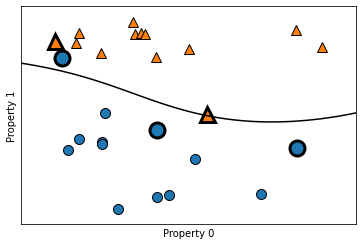

In [49]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됩니다.
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("Property 0")
plt.ylabel("Property 1")

이 그림에서 `SVM`은 매우 부드러운 비선형 경계를 만들었다.<br>
여기서 사용한 두 매개변수 `C`와 `gamma`에 대해 자세히 살펴보자.

<br>

---

#### <u>SVM 매개변수 튜닝</u>

<br>

- `gamma` 매개변수
    - 커널 폭의 역수 
    - 훈련 샘플이 미치는 영향의 범위를 결정
    - `gamma` ⇩ ∝ 넓은 영역(훈련 샘플의 영향 범위⇧)
    - `gamma` ⇧ ∝ 제한된 영역(훈련 샘플의 영향 범위⇩)
- `C` 매개변수
    - 선형 모델에서 사용한 것과 비슷한 규제 매개변수
    - 각 포인트의 중요도(dual_coef_값)을 제한시킨다.
    
<br>

설명으로는 감이 오지 않기 때문에 해당 매개변수들을 다르게 했을 때 어떻게 변경되는지 살펴보자.

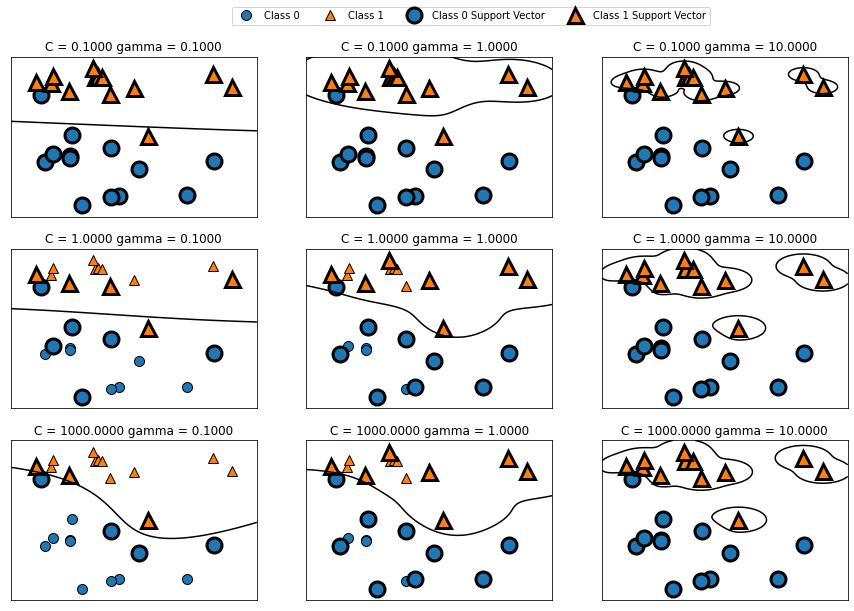

In [53]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["Class 0", "Class 1", "Class 0 Support Vector", "Class 1 Support Vector"],
                  ncol=4, loc=(.9, 1.2))

왼쪽에서 오른쪽으로 가면서 `gamma`매개변수를 (0.1, 1, 10)으로 증가 시켯다.<br>
작은 `gamma` 값은 가우시안 커널의 반경을 크게하여 많은 포인트들이 가까이 있는 것으로 고려된다.<br>
그래서 왼쪽 그림의 `결정경계`는 매우 부드럽고, 오른쪽으로 갈수록 결정 경계는 하나의 포인트에 대해 민감해진다.<br>
작은 `gamma`값이 `결정경계`를 천천히 바뀌게 하므로 모델의 복잡도를 낮춘다.<br>
하지만, 큰 `gamma`값은 더 복잡한 모델을 만든다.

<br>

위에서 아래로는 `C`매개변수를 (0.1, 1, 1000)으로 증가시켯다.<br>
선형 모델에서 작은 `C`는 매우 제약이 큰 모델을 만들고 각 포인트의 영향력은 작아지게 한다.<br>
`C`을 증가시키면 이 포인트들이 모델에 큰 영향을 주며 `결정경계`를 휘어서 정확하게 구분하려고 한다.

<br>

`RBF 커널 SVM`을 유방암 데이터셋에 적용해보자.<br>
(기본값 C=1, gamma = 1/n_features를 사용한다.)

In [120]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

svc = SVC()
svc.fit(X_train, y_train)

print("훈련 세트 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}".format(svc.score(X_test, y_test)))

훈련 세트 정확도: 0.90
테스트 세트 정확도: 0.94


결과를 보아 `과대적합`되어있음을 파악할 수 있다.<br>
`SVM`은 잘 작동하는 편이지만 매개변수 설정과 데이터 스케일에 매우 민감하다.<br>
특히 입력 특성의 범위가 비슷해야한다.<br>
각 특성의 최솟값과 최댓값을 로그 스케일로 나타내보자.

Text(0, 0.5, 'Property Size')

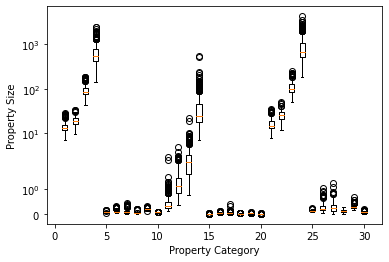

In [117]:
plt.boxplot(X_train, manage_ticks = False)
plt.yscale("symlog")
plt.xlabel("Property Category")
plt.ylabel("Property Size")

그래프를 보니 유방암 데이터셋의 특성은 자릿수 자체가 완전히 다르다는 것을 파악할 수 있다.<br>
이것은 일부 모델에서도 문제가 될 수 있지만, `커널 SVM`에서는 영향이 아주 크다.<br>


<br>

---

#### <u>SVM을 위한 데이터 전처리</u>

위 문제를 해결하는 방법 하나는 특성 값의 범위가 비슷해지도록 조정하는 것이다.<br>
`커널 SVM`에서 모든 특성 값을 평균이 0이고, 단위 분산이 되도록 하거나, 0과 1사이로 맞추는 방법을 많이 사용한다.

<br>

차후에 `StandardScaler`와 `MinMaxScaler` 전처리 메서드를 사용하는 방법에 관하여 다룰 것이다.

<br>

어떤 전처리 방법이 좋은지는 데이터셋의 성질에 따라 다르다. 여기서는 직접 변환시켜보자.

In [121]:
# 훈련 세트에서 특성별 최솟값 계산
min_on_training = X_train.min(axis=0)
# 훈련 세트에서 특성별 (최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 훈련 데이터에 최솟값을 빼고 범위로 나누면
# 각 특성에 대해 최솟값은 0, 최대값은 1입니다.
X_train_scaled = (X_train - min_on_training) / range_on_training
print("특성별 최소 값\n{}".format(X_train_scaled.min(axis=0)))
print("특성별 최대 값\n {}".format(X_train_scaled.max(axis=0)))

특성별 최소 값
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
특성별 최대 값
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [122]:
# 테스트 세트에도 같은 작업을 적용하지만
# 훈련 세트에서 계산한 최솟값과 범위를 사용합니다(자세한 내용은 3장에 있습니다).
X_test_scaled = (X_test - min_on_training) / range_on_training

In [123]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.984
테스트 세트 정확도: 0.972


데이터 스케일을 조정하니 결과가 달라졌다.<br>
하지만 훈련 세트와 테스트 세트가 비슷하기 때문에 `과소적합`된 상태이다.<br>
여기서 `C`나 `gamma`값을 증가시켜 좀 더 복잡한 모델을 만들 수 있다.

In [124]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.958


---

#### <u>장단점</u>

현재 포스팅에서 `커널 서포트 백터 머신`를 도출해내기 까지 다음의 과정으로 단축하여 설명할 수 있다.
- 저차원 데이터셋에서 `SVM` 선형 모델은 매우 제한적인 문제가 있었다.
- 특성을 늘리면 이를 해결할 수 있다.
- 특성을 늘리기 위해서는 고차항 다항식을 고려해야한다.
- 이를 위한 방법으로 `커널`이 존재한다.
- `c`와 `gamma`를 이용한 `커널 서포트 백터 머신`을 사용하여 좀 더 유연한 모델을 구성할 수 있다.

<br>



- 장점 
    - 다양한 데이터 셋에서 잘 작동하는 강력한 모델이다.
    - 데이터의 특성이 몇개 되지 않더라도 복잡한 결정 경계를 형성할 수 있다.
    - 특히, 저차원과 고차원 데이터(즉 특성이 적거나 많을 때)에서 잘 작동한다.
    
- 단점
    - 샘플이 많을 때는 잘 맞지 않는다.<br>1만개의 샘플 정도면 괜찮겠지만, 10만개 이상의 데이터에서는 속도와 메모리 관점에서 도전적인 과제이다.
    - <u>데이터 전처리와 매개변수 설정에 매우 매우 매우 신경을 많이 써야 한다</u>
        - 그래서 요즘은 데이터 전처리를 거의 하지 않거나 필요 없는 `랜덤 포레스트`/`그레디언트 부스팅` 같은 `트리`기반의 모델을 잘 사용한다.
    - SVM모델은 분석하기도 어렵다. 그래서 예측이 어떻게 결정되었는지 이해하기 어렵고 비전문가에게도 설명하기 난해하다.
    
<br>

위와 같은 단점들이 있지만, 모든 특성이 비슷한 단위이고(ex. 모든 값이 픽셀의 컬러 강도) 스케일이 비슷하면 `커널 서포트 백터 머신`을 시도해볼 만하다.

<br>

---

### References

- 안드레아스 뮐러, 세라 가이도, 『파이썬 라이브러리를 활용한 머신러닝』, 박해선, 한빛미디어(2017)